<a href="https://colab.research.google.com/github/ahmedmusawir/modern-react-agents-youtube/blob/main/VIDEO_1_STEP_1_Basic_Weather_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SETUP

### INSTALLATIONS

In [ ]:
!pip install -q langchain
!pip install -q langchain_openai
!pip install -q langchain_community
!pip install -q langgraph
!pip show langchain
!pip show langgraph

Name: langchain
Version: 0.3.15
Summary: Building applications with LLMs through composability
Home-page: https://github.com/langchain-ai/langchain
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: aiohttp, langchain-core, langchain-text-splitters, langsmith, numpy, pydantic, PyYAML, requests, SQLAlchemy, tenacity
Required-by: langchain-community
Name: langgraph
Version: 0.2.67
Summary: Building stateful, multi-actor applications with LLMs
Home-page: https://www.github.com/langchain-ai/langgraph
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: langchain-core, langgraph-checkpoint, langgraph-sdk
Required-by: 


### LOADING API KEY

In [ ]:
import os
os.environ["OPENAI_API_KEY"] ="sk-proj-ulX3********************U8CUAYWg7y8Ge8pROt"

### TESTING THE MODEL RESPONSE

In [ ]:
from langchain_openai import ChatOpenAI
import pprint

# Create an instance of the OpenAI class
llm = ChatOpenAI(model="gpt-4o")

# Generate text
prompt = "Who is Trump (in one sentence)"
response = llm.invoke(prompt)

# print(response)
pprint.pprint(response.content)

('Donald Trump is a businessman and television personality who served as the '
 '45th President of the United States from 2017 to 2021.')


# ReAct Agent in My Graph

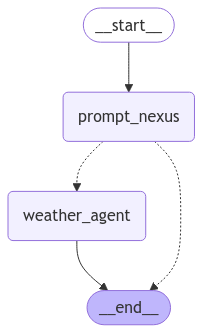

In [ ]:
from typing import TypedDict, Annotated
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import create_react_agent
from langgraph.graph.message import add_messages

# Define the state
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Initialize the graph builder
graph_builder = StateGraph(State)

# Define the LLM
llm = ChatOpenAI(model_name='gpt-4o', temperature=0.5)

# Define the prompt_nexus node
def prompt_nexus(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# Add the prompt_nexus node to the graph
graph_builder.add_node("prompt_nexus", prompt_nexus)

# Define the weather tool
@tool
def get_weather(city: str):
    """Call to get the current weather. Use this anytime asked about the weather"""

    if city.lower() == "paris":
        return "It's always sunny in Paris."
    else:
        return "It's cold and wet."

# Create the weather agent
weather_agent = create_react_agent(llm, tools=[get_weather])

# Add Agent Node
graph_builder.add_node("weather_agent", weather_agent)

# Define the routing function
def route_to_weather(state: State):
    if any("weather" in message.content.lower() for message in state["messages"]):
        return "weather_agent"
    return END

# Add conditional edges
graph_builder.add_conditional_edges("prompt_nexus", route_to_weather, {"weather_agent": "weather_agent", END: END})

# Add normal edge
graph_builder.add_edge("weather_agent", END)

# Set entry point
graph_builder.set_entry_point("prompt_nexus")

# Compile the graph
graph = graph_builder.compile()
graph


## Quick Test

In [ ]:
# response = graph.invoke({'messages': ('user', 'who is donald trump?')})
# response = graph.invoke({'messages': ('user', 'how is the weather in paris?')})
response = graph.invoke({'messages': ('user', 'how about the weather in london?')})

print('Assistant: ', response['messages'][-1].content)

Assistant:  The current weather in London is cold and wet.
